# Tutorial - Using `timeseries` APIs

> Using `Datasets` and `DataBlock`

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [10]:
from fastai2.torch_basics import *
from fastai2.data.all import *

In [7]:
from fastai2.layers import *
from fastai2.learner import *
from fastai2.metrics import *
from fastai2.callback.schedule import *
from fastai2.callback.hook import *
from fastai2.callback.progress import *
from fastai2.callback.mixup import *
from fastai2.optimizer import *

In [43]:
from timeseries.tsdata import *
from timeseries.core import *
from timeseries.models.inception_time import *

In [11]:
path_data = Config().data
path_data, path_data.ls()

(Path('C:/Users/fh/.fastai/data'),
 (#23) [Path('C:/Users/fh/.fastai/data/adult_sample'),Path('C:/Users/fh/.fastai/data/adult_sample.tgz'),Path('C:/Users/fh/.fastai/data/biwi_sample'),Path('C:/Users/fh/.fastai/data/bluebook-for-bulldozers.zip'),Path('C:/Users/fh/.fastai/data/bulldozers'),Path('C:/Users/fh/.fastai/data/camvid'),Path('C:/Users/fh/.fastai/data/camvid.tgz'),Path('C:/Users/fh/.fastai/data/camvid_tiny'),Path('C:/Users/fh/.fastai/data/coco_tiny'),Path('C:/Users/fh/.fastai/data/imagenette-160')...])

In [12]:
dsname =  'NATOPS' #'NATOPS', 'LSST', 'Wine', 'Epilepsy', 'HandMovementDirection'

In [15]:
path = download_unzip_data_UCR(dsname=dsname)
path.ls()

(#54) [Path('C:/Users/fh/.fastai/data/NATOPS/NATOPS.jpg'),Path('C:/Users/fh/.fastai/data/NATOPS/NATOPS.txt'),Path('C:/Users/fh/.fastai/data/NATOPS/NATOPSDimension10_TEST.arff'),Path('C:/Users/fh/.fastai/data/NATOPS/NATOPSDimension10_TRAIN.arff'),Path('C:/Users/fh/.fastai/data/NATOPS/NATOPSDimension11_TEST.arff'),Path('C:/Users/fh/.fastai/data/NATOPS/NATOPSDimension11_TRAIN.arff'),Path('C:/Users/fh/.fastai/data/NATOPS/NATOPSDimension12_TEST.arff'),Path('C:/Users/fh/.fastai/data/NATOPS/NATOPSDimension12_TRAIN.arff'),Path('C:/Users/fh/.fastai/data/NATOPS/NATOPSDimension13_TEST.arff'),Path('C:/Users/fh/.fastai/data/NATOPS/NATOPSDimension13_TRAIN.arff')...]

In [16]:
fname_train = path_data/f'{dsname}/{dsname}_Train.arff'
fname_test = path_data/f'{dsname}/{dsname}_Test.arff'
fnames = [fname_train, fname_test]
fnames

[Path('C:/Users/fh/.fastai/data/NATOPS/NATOPS_Train.arff'),
 Path('C:/Users/fh/.fastai/data/NATOPS/NATOPS_Test.arff')]

In [59]:
data = TSData()
train_x, train_y = data.load([fname_train, fname_test])
print(data)

TSData:
 Datasets names (concatenated): ['NATOPS_Train', 'NATOPS_Test']
 Filenames: [Path('C:/Users/fh/.fastai/data/NATOPS/NATOPS_Train.arff'), Path('C:/Users/fh/.fastai/data/NATOPS/NATOPS_Test.arff')]
 Data shape: (360, 24, 51)
 Targets shape: (360,)
 Nb Samples: 360
 Nb Channels: 24
 Sequence Length: 51


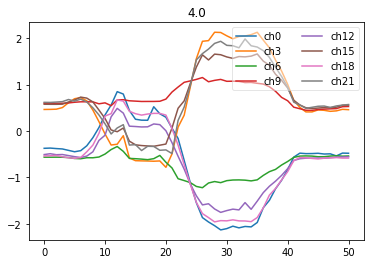

In [18]:
items = data.get_items()
idx = 0
x1, y1 = data.x[idx],  data.y[idx]

show_timeseries(x1, title=y1, chs=range(0,24,3))


In [19]:
seed = 42
splits = RandomSplitter(seed=seed)(range_of(items))
splits

((#288) [304,281,114,329,115,130,338,294,94,310...],
 (#72) [222,27,96,253,274,35,160,172,302,146...])

## Using `Datasets` class

In [22]:
tfm_norm = SelfNormalize(scale_type='normalize', scale_subtype = 'per_sample', scale_range=(0, 1))

tfms = [[ToTensorTS(as_item=True)], [LabelTS(as_item=True), Categorize()]]

### Create a Datasets object

In [29]:
# Create a dataset
ds = Datasets(items, tfms, splits=splits)

3.0


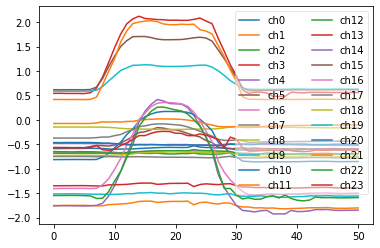

In [30]:
ax = show_at(ds, 2, figsize=(1,1))

### Create a Dataloader object

In [31]:
bs = 128                            
# Normalize at batch time
batch_tfms = [tfm_norm]
dls = ds.dataloaders( bs=bs, val_bs=bs * 2, after_batch=batch_tfms, num_workers=0, device=default_device()) 

Could not do one pass in your dataloader, there is something wrong in it


## Using `DataBlock` class

In [41]:
tsdb = DataBlock(blocks=(TSBlock, CategoryBlock),
                   get_items=get_ts_items,
                   get_x=lambda x:x[0],
                   splitter=RandomSplitter(seed=seed),
                   get_y=lambda x:x[1],
                   batch_tfms = batch_tfms)

In [45]:
tsdb.summary([fname_train, fname_test])

Setting-up type transforms pipelines
Found 360 items
2 datasets of sizes 288,72
Setting up Pipeline: <lambda> -> ToTensorTSBlock
Setting up Pipeline: <lambda> -> Categorize

Building one sample
  Pipeline: <lambda> -> ToTensorTSBlock
    starting from
      ([[-0.540579 -0.54101  -0.540603 ... -0.56305  -0.566314 -0.553712]
 [-1.539567 -1.540042 -1.538992 ... -1.532014 -1.534645 -1.536015]
 [-0.608539 -0.604609 -0.607679 ... -0.593769 -0.592854 -0.599014]
 ...
 [ 0.454542  0.449924  0.453195 ...  0.480281  0.45537   0.457275]
 [-1.411445 -1.363464 -1.390869 ... -1.468123 -1.368706 -1.386574]
 [-0.473406 -0.453322 -0.463813 ... -0.440582 -0.427211 -0.435581]], 2.0)
    applying <lambda> gives
      [[-0.540579 -0.54101  -0.540603 ... -0.56305  -0.566314 -0.553712]
 [-1.539567 -1.540042 -1.538992 ... -1.532014 -1.534645 -1.536015]
 [-0.608539 -0.604609 -0.607679 ... -0.593769 -0.592854 -0.599014]
 ...
 [ 0.454542  0.449924  0.453195 ...  0.480281  0.45537   0.457275]
 [-1.411445 -1.36346

In [46]:
dls = tsdb.dataloaders([fname_train, fname_test], num_workers=0, device=default_device())

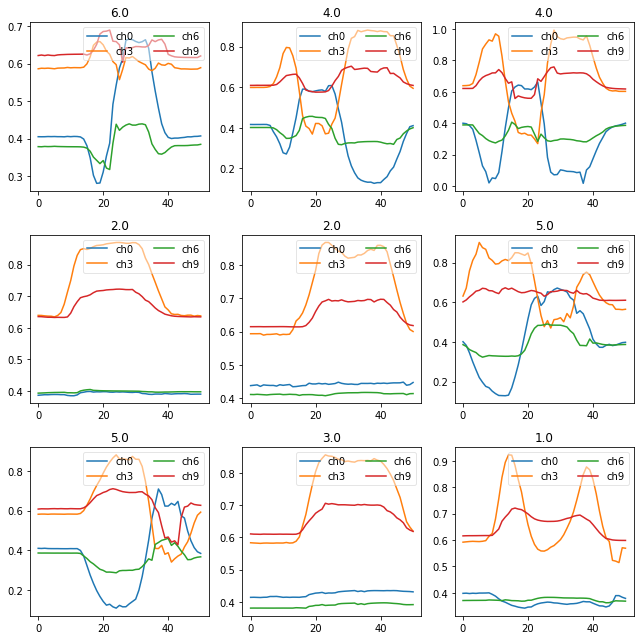

In [48]:
dls.show_batch(ctxs=None, max_n=9, chs=range(0,12,3))

## Pass data to dataloaders() method instead do DataBlock get_items attribute (see DataBlock example here above)

In [49]:
tsdb_2 = DataBlock(blocks=(TSBlock, CategoryBlock),
                   get_x=lambda x:x[0],
                   splitter=RandomSplitter(seed=seed),
                   get_y=lambda x:x[1])

In [50]:
dls_2 = tsdb_2.dataloaders(data.get_items(), batch_tfms=batch_tfms, num_workers=0, device=default_device())

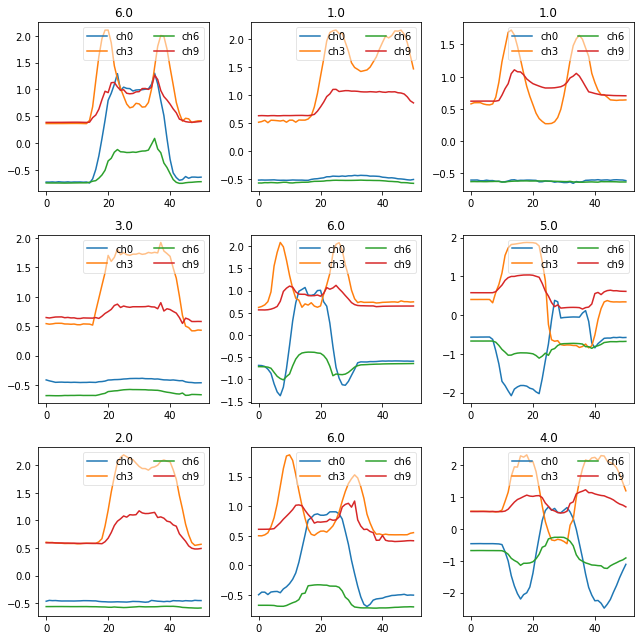

In [51]:
dls_2.show_batch(ctxs=None, max_n=9, chs=range(0,12,3))

## Train Model

In [52]:
# Number of channels (i.e. dimensions in ARFF and TS files jargon)
c_in = data.n_channels
# Number of classes
c_out= len(dbch.vocab) 
c_in,c_out

(24, 6)

### Create model

In [53]:
model = create_inception(c_in, c_out).to(device=default_device())
model

Sequential(
  (0): SequentialEx(
    (layers): ModuleList(
      (0): InceptionModule(
        (convs): ModuleList(
          (0): Conv1d(24, 32, kernel_size=(39,), stride=(1,), padding=(19,), bias=False)
          (1): Conv1d(24, 32, kernel_size=(19,), stride=(1,), padding=(9,), bias=False)
          (2): Conv1d(24, 32, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
        )
        (maxpool_bottleneck): Sequential(
          (0): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
          (1): Conv1d(24, 32, kernel_size=(1,), stride=(1,), bias=False)
        )
        (bn_relu): Sequential(
          (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU()
        )
      )
    )
  )
  (1): SequentialEx(
    (layers): ModuleList(
      (0): InceptionModule(
        (bottleneck): Conv1d(128, 32, kernel_size=(1,), stride=(1,))
        (convs): ModuleList(
          (0): Conv1d(32, 32, kernel_size=(39

### Create Learner object

In [54]:
#Learner
opt_func = partial(Adam, lr=3e-3, wd=0.01)     
loss_func = LabelSmoothingCrossEntropy() 
learn = Learner(dls, model, opt_func=opt_func, loss_func=loss_func, metrics=accuracy)

print(learn.summary())

Sequential (Input shape: ['64 x 24 x 51'])
Layer (type)         Output Shape         Param #    Trainable 
Conv1d               64 x 32 x 51         29,952     True      
________________________________________________________________
Conv1d               64 x 32 x 51         14,592     True      
________________________________________________________________
Conv1d               64 x 32 x 51         6,912      True      
________________________________________________________________
MaxPool1d            64 x 24 x 51         0          False     
________________________________________________________________
Conv1d               64 x 32 x 51         768        True      
________________________________________________________________
BatchNorm1d          64 x 128 x 51        256        True      
________________________________________________________________
ReLU                 64 x 128 x 51        0          False     
_______________________________________________________

### LR find 

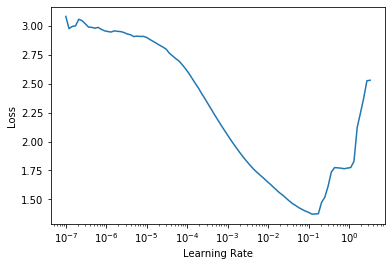

In [55]:
learn.lr_find()

### Train

In [56]:
epochs = 20      
lr_max = 1e-3      
pct_start = .7   
moms=(0.95,0.85,0.95)   
wd = 1e-2

learn.fit_one_cycle(epochs, lr_max=lr_max, pct_start=pct_start,  moms=moms, wd=wd)
learn.save('stage_1')

epoch,train_loss,valid_loss,accuracy,time
0,2.733384,1.796509,0.152778,00:03
1,2.377350,1.800664,0.152778,00:03
2,2.057037,1.805881,0.152778,00:03
3,1.807252,1.809706,0.152778,00:03
4,1.590556,1.813165,0.152778,00:03
5,1.416805,1.812576,0.305556,00:03
6,1.283712,1.790047,0.347222,00:03
7,1.179945,1.760131,0.375000,00:03
8,1.095918,1.577281,0.388889,00:03
9,1.022956,1.460286,0.430556,00:03


### Plot loss function

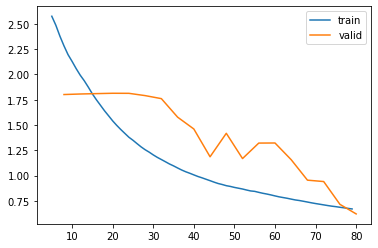

In [57]:
learn.recorder.plot_loss()

## Show results

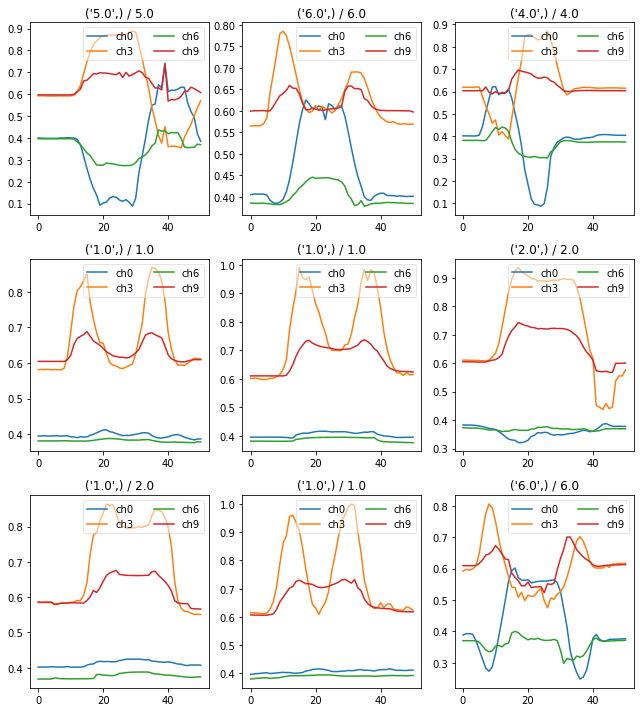

In [58]:
learn.show_results(max_n=9, chs=range(0,12,3))